<a href="https://colab.research.google.com/github/NiyonshutiDavid/ML-Pipeline_assignment/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libaries

In [28]:
#Installing libraries in the virtual environment
!pip install pandas 
!pip install scikit-learn 
!pip install numpy 
!pip install matplotlib 
!pip install seaborn


In [29]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import joblib

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    classification_report, confusion_matrix
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

# Loading the dataset

In [30]:


# Load the dataset
df = pd.read_csv('data/heart.csv')

# Check for missing values
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [31]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Data cleaning and processing

In [32]:
# Replace 0 values in Cholesterol with median (since it's likely missing data)
df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())

# Check for other impossible values in RestingBP (blood pressure can't be 0)
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())

# Check MaxHR (maximum heart rate) for unrealistic values
df = df[(df['MaxHR'] > 40) & (df['MaxHR'] < 220)]  # Reasonable heart rate range

# Standardize categorical values (ensure consistent capitalization/spacing)


In [33]:
# Standardize categorical values (ensure consistent capitalization/spacing)
df['ChestPainType'] = df['ChestPainType'].str.strip().str.upper()
df['RestingECG'] = df['RestingECG'].str.strip()
df['ST_Slope'] = df['ST_Slope'].str.strip()

# Convert binary columns to 0/1
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})

# Define reasonable ranges for each numerical feature


In [34]:
# Define reasonable ranges for each numerical feature
reasonable_ranges = {
    'Age': (20, 100),
    'RestingBP': (80, 200),
    'Cholesterol': (100, 600),  # Upper limit for extreme but possible cases
    'MaxHR': (40, 220),
    'Oldpeak': (0, 6.5)  # ST depression range
}

# Clip values to these ranges
for col, (min_val, max_val) in reasonable_ranges.items():
    df[col] = df[col].clip(min_val, max_val)

# Verify no missing values remain


In [35]:
# Verify no missing values remain
assert df.isnull().sum().sum() == 0

# Verify all categorical values are valid
valid_chest_pain = {'ATA', 'NAP', 'ASY', 'TA'}
assert set(df['ChestPainType'].unique()).issubset(valid_chest_pain)

valid_ecg = {'Normal', 'ST', 'LVH'}
assert set(df['RestingECG'].unique()).issubset(valid_ecg)

valid_slope = {'Up', 'Flat', 'Down'}
assert set(df['ST_Slope'].unique()).issubset(valid_slope)

In [36]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


# Binary encoding (already done in previous cleaning)

In [37]:
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})

# Ordinal encoding for ST_Slope (ordered categories)
st_slope_order = {'Up': 0, 'Flat': 1, 'Down': 2}
df['ST_Slope_encoded'] = df['ST_Slope'].map(st_slope_order)

# Ordinal encoding for RestingECG
ecg_order = {'Normal': 0, 'ST': 1, 'LVH': 2}
df['RestingECG_encoded'] = df['RestingECG'].map(ecg_order)

# One-hot encoding for ChestPainType (nominal)
chest_pain_dummies = pd.get_dummies(df['ChestPainType'], prefix='ChestPain')
df = pd.concat([df, chest_pain_dummies], axis=1)

# Drop original categorical columns
df = df.drop(['ChestPainType', 'RestingECG', 'ST_Slope'], axis=1)

# Verify the transformations
print(df[['ST_Slope_encoded', 'RestingECG_encoded']].head())
print(df.filter(like='ChestPain_').head())

   ST_Slope_encoded  RestingECG_encoded
0                 0                   0
1                 1                   0
2                 0                   1
3                 1                   0
4                 0                   0
   ChestPain_ASY  ChestPain_ATA  ChestPain_NAP  ChestPain_TA
0          False           True          False         False
1          False          False           True         False
2          False           True          False         False
3           True          False          False         False
4          False          False           True         False


In [38]:
df.head(5)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ST_Slope_encoded,RestingECG_encoded,ChestPain_ASY,ChestPain_ATA,ChestPain_NAP,ChestPain_TA
0,40,NaN,140,289,0,172,NaN,0.0,0,0,0,False,True,False,False
1,49,NaN,160,180,0,156,NaN,1.0,1,1,0,False,False,True,False
2,37,NaN,130,283,0,98,NaN,0.0,0,0,1,False,True,False,False
3,48,NaN,138,214,0,108,NaN,1.5,1,1,0,True,False,False,False
4,54,NaN,150,195,0,122,NaN,0.0,0,0,0,False,False,True,False


# Convert boolean columns to integer type (0s and 1s)

In [39]:
# Convert boolean columns to integer type (0s and 1s)
boolean_columns = ['ChestPain_ASY', 'ChestPain_ATA', 'ChestPain_NAP', 'ChestPain_TA']
for col in boolean_columns:
    df[col] = df[col].astype(int)

# Verify the conversion
print(df[boolean_columns].head())

   ChestPain_ASY  ChestPain_ATA  ChestPain_NAP  ChestPain_TA
0              0              1              0             0
1              0              0              1             0
2              0              1              0             0
3              1              0              0             0
4              0              0              1             0


In [40]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ST_Slope_encoded,RestingECG_encoded,ChestPain_ASY,ChestPain_ATA,ChestPain_NAP,ChestPain_TA
0,40,NaN,140,289,0,172,NaN,0.0,0,0,0,0,1,0,0
1,49,NaN,160,180,0,156,NaN,1.0,1,1,0,0,0,1,0
2,37,NaN,130,283,0,98,NaN,0.0,0,0,1,0,1,0,0
3,48,NaN,138,214,0,108,NaN,1.5,1,1,0,1,0,0,0
4,54,NaN,150,195,0,122,NaN,0.0,0,0,0,0,0,1,0


#saving the clean data


In [41]:
#saving the clean data
df.to_csv('data/heart_cleaned.csv', index=False)

# Load the cleaned Data

In [42]:
# 2. Load your cleaned dataset
df = pd.read_csv('data/heart_cleaned.csv')

# Train-test split and Scaling

In [43]:
missing=pd.read_csv('data/heart_cleaned.csv')
# Check needed columns for prediction to create a update the patient table
columns= df.columns.tolist()
print("Columns needed for prediction:", columns)
print("check if there is missing values:", df.isnull().sum().sum() == 0)


Columns needed for prediction: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ST_Slope_encoded', 'RestingECG_encoded', 'ChestPain_ASY', 'ChestPain_ATA', 'ChestPain_NAP', 'ChestPain_TA']
check if there is missing values: False


In [44]:
# 1. Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Prepare dictionary to store results
model_results = {}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


# Training the Logic regression model

In [45]:
def model_1(X_train_scaled, X_test_scaled, y_train, y_test):
    """
    Trains and evaluates a Logistic Regression model on scaled heart disease data.

    Returns:
        model_lr: trained logistic regression model
        y_pred: binary predictions on test set
        metrics: dict of accuracy, f1, recall, precision
    """

    # === Train Logistic Regression Model ===
    model_lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2', random_state=42)
    model_lr.fit(X_train_scaled, y_train)

    # === Predict on test set ===
    y_pred = model_lr.predict(X_test_scaled)

    # === Compute metrics ===
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # === Display results ===
    print("\n✅ Logistic Regression Results (model_1):")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Disease (0)', 'Has Disease (1)']))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"\nPredicted 'Has Disease' (1): {np.sum(y_pred == 1)}")
    print(f"Predicted 'No Disease' (0): {np.sum(y_pred == 0)}")

    # === Save model ===
    save_path = "saved_models/logistic_regression_model.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(model_lr, save_path)
    print(f"\n📦 model_1 saved at: {save_path}")

    # === Return everything for reuse ===
    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision
    }

    return model_lr, y_pred, metrics


In [49]:
# Check if there is NaN values in the dataset
if df.isnull().values.any():
    print("There are NaN values in the dataset. Please handle them before proceeding.")
    print("These are columns with NaN values:", df.columns[df.isnull().any()].tolist())
else:
    print("No NaN values found. Proceeding with model training...")

There are NaN values in the dataset. Please handle them before proceeding.
These are columns with NaN values: ['Sex', 'ExerciseAngina']


In [46]:
# === Trigger the training and print results ===
model_lr, y_pred, metrics = model_1(X_train_scaled, X_test_scaled, y_train, y_test)

# Optional: Store the results
model_results['model_1'] = {
    'model': model_lr,
    'metrics': metrics
}


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Training the Random forest model

In [ ]:
def model_2(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates a Random Forest classifier on heart disease data.

    Returns:
        model_rf: trained random forest model
        y_pred: binary predictions on test set
        metrics: dict of accuracy, f1, recall, precision
    """

    # === Train Random Forest Model ===
    model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
    model_2.fit(X_train, y_train)

    # === Predict on test set ===
    y_pred = model_2.predict(X_test)

    # === Compute metrics ===
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # === Display results ===
    print("\n✅ Random Forest Results (model_rf):")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Disease (0)', 'Has Disease (1)']))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"\nPredicted 'Has Disease' (1): {np.sum(y_pred == 1)}")
    print(f"Predicted 'No Disease' (0): {np.sum(y_pred == 0)}")

    # === Save model ===
    save_path = "saved_models/random_forest_model.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(model_2, save_path)
    print(f"\n📦 model_rf saved at: {save_path}")

    # === Return everything for reuse ===
    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision
    }

    return model_2, y_pred, metrics


In [ ]:
model_rf, y_pred_rf, metrics_rf = model_2(X_train, X_test, y_train, y_test)



✅ Random Forest Results (model_rf):
Accuracy:  0.8750
F1 Score:  0.8900
Recall:    0.8692
Precision: 0.9118

Classification Report:
                 precision    recall  f1-score   support

 No Disease (0)       0.83      0.88      0.86        77
Has Disease (1)       0.91      0.87      0.89       107

       accuracy                           0.88       184
      macro avg       0.87      0.88      0.87       184
   weighted avg       0.88      0.88      0.88       184


Confusion Matrix:
[[68  9]
 [14 93]]

Predicted 'Has Disease' (1): 102
Predicted 'No Disease' (0): 82

📦 model_rf saved at: saved_models/random_forest_model.pkl


# Training the NN Model using Adam as the optimizer and l1 as the regularizer

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4832 - loss: 4.9558 - val_accuracy: 0.6190 - val_loss: 3.2677
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7496 - loss: 2.8241 - val_accuracy: 0.7823 - val_loss: 1.7407
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7647 - loss: 1.4972 - val_accuracy: 0.8095 - val_loss: 1.0125
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8114 - loss: 0.9282 - val_accuracy: 0.8299 - val_loss: 0.7443
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8234 - loss: 0.7170 - val_accuracy: 0.8503 - val_loss: 0.6590
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8104 - loss: 0.7295 - val_accuracy: 0.8503 - val_loss: 0.6131
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8403 - loss: 0.6377 - val_accuracy: 0.8367 - val_loss: 0.6097
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8078 - loss: 0.6528 - val_accuracy: 0.8503 - val_loss: 0.

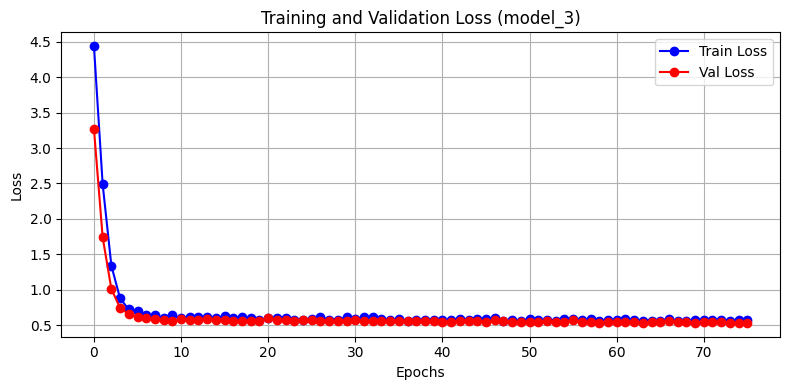


✅ Results for model_3 (Optimized Neural Network with 64-unit layer):
Accuracy:  0.8533
F1 Score:  0.8708
Recall:    0.8505
Precision: 0.8922

Confusion Matrix:
[[66 11]
 [16 91]]

Classification Report:
                 precision    recall  f1-score   support

 No Disease (0)       0.80      0.86      0.83        77
Has Disease (1)       0.89      0.85      0.87       107

       accuracy                           0.85       184
      macro avg       0.85      0.85      0.85       184
   weighted avg       0.86      0.85      0.85       184



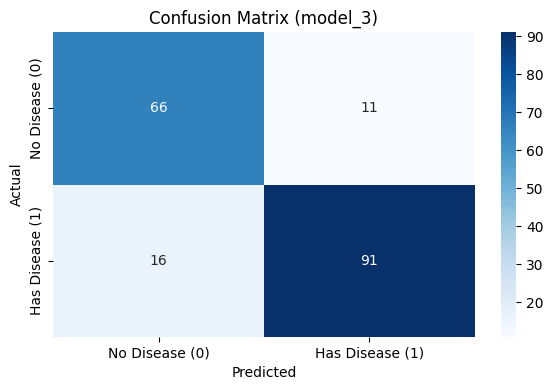


📦 model_3 has been saved to: saved_models/Adam_l1_model_3.keras


In [ ]:
# === 1. Define model_3 with additional first Dense(64) layer ===

model_3 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# === 2. Compile the model ===
model_3.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 3. Early stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# === 4. Train the model ===
history_3 = model_3.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === 5. Plot training and validation loss ===
plt.figure(figsize=(8, 4))
plt.plot(history_3.history['loss'], 'bo-', label='Train Loss')
plt.plot(history_3.history['val_loss'], 'ro-', label='Val Loss')
plt.title('Training and Validation Loss (model_3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Evaluate the model on the test set ===
y_pred3 = (model_3.predict(X_test_scaled, verbose=0) > 0.5).astype(int)

accuracy_3 = accuracy_score(y_test, y_pred3)
f1_3 = f1_score(y_test, y_pred3)
recall_3 = recall_score(y_test, y_pred3)
precision_3 = precision_score(y_test, y_pred3)

print(f"\n✅ Results for model_3 (Optimized Neural Network with 64-unit layer):")
print(f"Accuracy:  {accuracy_3:.4f}")
print(f"F1 Score:  {f1_3:.4f}")
print(f"Recall:    {recall_3:.4f}")
print(f"Precision: {precision_3:.4f}")

# === 7. Confusion Matrix ===
cm3 = confusion_matrix(y_test, y_pred3)
print("\nConfusion Matrix:")
print(cm3)

print("\nClassification Report:")
print(classification_report(y_test, y_pred3, target_names=['No Disease (0)', 'Has Disease (1)']))

# === 8. Plot confusion matrix ===
plt.figure(figsize=(6, 4))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease (0)', 'Has Disease (1)'],
            yticklabels=['No Disease (0)', 'Has Disease (1)'])
plt.title('Confusion Matrix (model_3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === 9. Save the model ===
save_path = "saved_models/Adam_l1_model_3.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model_3.save(save_path)

print(f"\n📦 model_3 has been saved to: {save_path}")


# Training the NN Model using SGD as the optimizer and l2 as the regularizer

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5790 - loss: 1.5401 - val_accuracy: 0.7143 - val_loss: 1.4517
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6753 - loss: 1.4184 - val_accuracy: 0.7823 - val_loss: 1.3246
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6874 - loss: 1.3218 - val_accuracy: 0.7891 - val_loss: 1.2133
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7787 - loss: 1.1843 - val_accuracy: 0.8095 - val_loss: 1.1161
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7995 - loss: 1.1250 - val_accuracy: 0.8095 - val_loss: 1.0548
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8042 - loss: 0.9981 - val_accuracy: 0.8231 - val_loss: 1.0024
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8361 - loss: 0.9716 - val_accuracy: 0.8435 - val_loss: 0.9515
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8325 - loss: 0.9235 - val_accuracy: 0.8367 - val_loss: 0.

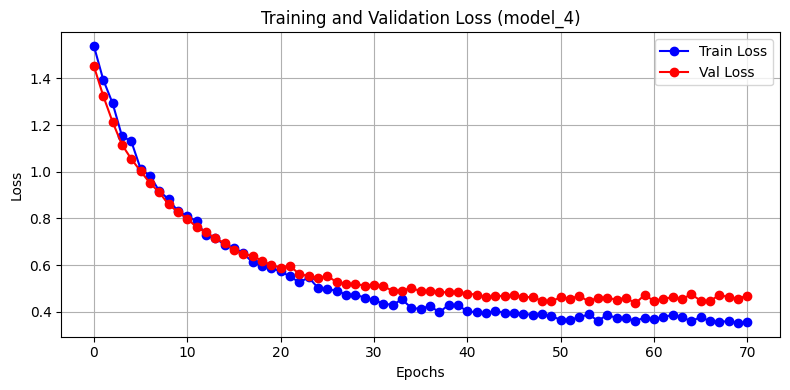


✅ Results for model_4 (Neural Network with SGD & L2):
Accuracy:  0.8696
F1 Score:  0.8835
Recall:    0.8505
Precision: 0.9192

Confusion Matrix:
[[69  8]
 [16 91]]

Classification Report:
                 precision    recall  f1-score   support

 No Disease (0)       0.81      0.90      0.85        77
Has Disease (1)       0.92      0.85      0.88       107

       accuracy                           0.87       184
      macro avg       0.87      0.87      0.87       184
   weighted avg       0.87      0.87      0.87       184



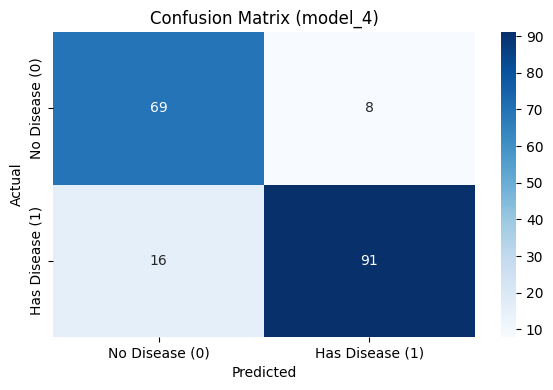


📦 model_4 has been saved to: saved_models/SGD_l2_model_4.keras


In [ ]:
# === 1. Define model_4 with L2 regularization and SGD optimizer ===

model_4 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# === 2. Compile the model ===
model_4.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 3. Early stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# === 4. Train the model ===
history_4 = model_4.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === 5. Plot training and validation loss ===
plt.figure(figsize=(8, 4))
plt.plot(history_4.history['loss'], 'bo-', label='Train Loss')
plt.plot(history_4.history['val_loss'], 'ro-', label='Val Loss')
plt.title('Training and Validation Loss (model_4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Evaluate the model on the test set ===
y_pred4 = (model_4.predict(X_test_scaled, verbose=0) > 0.5).astype(int)

accuracy_4 = accuracy_score(y_test, y_pred4)
f1_4 = f1_score(y_test, y_pred4)
recall_4 = recall_score(y_test, y_pred4)
precision_4 = precision_score(y_test, y_pred4)

print(f"\n✅ Results for model_4 (Neural Network with SGD & L2):")
print(f"Accuracy:  {accuracy_4:.4f}")
print(f"F1 Score:  {f1_4:.4f}")
print(f"Recall:    {recall_4:.4f}")
print(f"Precision: {precision_4:.4f}")

# === 7. Confusion Matrix ===
cm4 = confusion_matrix(y_test, y_pred4)
print("\nConfusion Matrix:")
print(cm4)

print("\nClassification Report:")
print(classification_report(y_test, y_pred4, target_names=['No Disease (0)', 'Has Disease (1)']))

# === 8. Plot confusion matrix ===
plt.figure(figsize=(6, 4))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease (0)', 'Has Disease (1)'],
            yticklabels=['No Disease (0)', 'Has Disease (1)'])
plt.title('Confusion Matrix (model_4)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === 9. Save the model ===
save_path = "saved_models/SGD_l2_model_4.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model_4.save(save_path)

print(f"\n📦 model_4 has been saved to: {save_path}")


# Comparing to see the best performing model

In [ ]:
# === Compare All Models and Identify the Best ===

models = {
    'model_1': model_lr,
    'model_2': model_rf,
    'model_3': model_3,
    'model_4': model_4,
}

metrics_summary = {}
best_name = None
best_acc = 0.0

print("Model Performance on Test Set:\n" + "-" * 72)
print(f"{'Model':<25} | {'Accuracy':<9} | {'F1 Score':<8} | {'Recall':<7} | {'Precision'}")
print("-" * 72)

for name, mdl in models.items():
    # Make predictions
    if name == 'model_1':
        y_pred = mdl.predict(X_test_scaled)  # scikit-learn
    else:
        if name == "model_2":  # Random Forest on unscaled data
            y_pred = mdl.predict(X_test)
        else:
            y_pred = (mdl.predict(X_test_scaled, verbose=0) > 0.5).astype(int)  # keras

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Store in dictionary
    metrics_summary[name] = {
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision
    }

    # Print formatted row
    print(f"{name:<25} | {acc:<9.4f} | {f1:<8.4f} | {recall:<7.4f} | {precision:.4f}")

    # Track best model
    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_model = mdl

print("-" * 72)
print(f"✅ Best model is **{best_name}** with Test Accuracy = {best_acc:.4f}")

# === Save Best Model ===
os.makedirs("saved_models", exist_ok=True)
if 'keras' in str(type(best_model)).lower():
    save_path = f"saved_models/{best_name}_best.keras"
    best_model.save(save_path)
else:
    save_path = f"saved_models/{best_name}_best.pkl"
    joblib.dump(best_model, save_path)

print(f"\n📦 Best model saved to: {save_path}")


Model Performance on Test Set:
------------------------------------------------------------------------
Model                     | Accuracy  | F1 Score | Recall  | Precision
------------------------------------------------------------------------
model_1                   | 0.8533    | 0.8696   | 0.8411  | 0.9000
model_2                   | 0.8750    | 0.8900   | 0.8692  | 0.9118
model_3                   | 0.8533    | 0.8708   | 0.8505  | 0.8922
model_4                   | 0.8696    | 0.8835   | 0.8505  | 0.9192
------------------------------------------------------------------------
✅ Best model is **model_2** with Test Accuracy = 0.8750

📦 Best model saved to: saved_models/model_2_best.pkl


In [50]:
# Check needed columns for prediction to create a update the patient table
columns= df.columns.tolist()
print("Columns needed for prediction:", columns)

Columns needed for prediction: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ST_Slope_encoded', 'RestingECG_encoded', 'ChestPain_ASY', 'ChestPain_ATA', 'ChestPain_NAP', 'ChestPain_TA']


In [52]:
print("on sample data:", df.head(1))

on sample data:    Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0   40  NaN        140          289          0    172             NaN   

   Oldpeak  HeartDisease  ST_Slope_encoded  RestingECG_encoded  ChestPain_ASY  \
0      0.0             0                 0                   0              0   

   ChestPain_ATA  ChestPain_NAP  ChestPain_TA  
0              1              0             0  
